# Download and Inspect the Collection

The dataset was created from the Chronicling America collection — over 21 million digitized newspaper pages (1756–1963) curated by the Library of Congress and NEH. They used 39,330 pages (1800–1920), representing 53 US states, to ensure wide geographic and temporal coverage.

Source: https://dl.acm.org/doi/pdf/10.1145/3626772.3657891

GitHub: https://github.com/DataScienceUIBK/ChroniclingAmericaQA?tab=readme-ov-file


In [1]:
import os

# 1. Imposta i percorsi basandoti su quanto trovato sopra
os.environ["JAVA_HOME"] = "/Library/Java/JavaVirtualMachines/temurin-11.jdk/Contents/Home"
# Incolla qui il percorso esatto trovato con il comando 'find' al punto 2
os.environ["JVM_PATH"] = "/Library/Java/JavaVirtualMachines/temurin-11.jdk/Contents/Home/lib/server/libjvm.dylib"

import pyterrier as pt

# 2. Inizializzazione corretta per il 2026
if not pt.java.started():
    pt.java.init()

print("PyTerrier inizializzato con successo!")



PyTerrier inizializzato con successo!


Java started and loaded: pyterrier.java.colab, pyterrier.java, pyterrier.java.24, pyterrier.terrier.java [version=5.11 (build: craig.macdonald 2025-01-13 21:29), helper_version=0.0.8]


In [2]:
%pip install -r requirements.txt

  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.0/8.0 MB 33.4 MB/s eta 0:00:00a 0:00:01
Using cached threadpoolctl-3.6.0-py3-none-any.whl (18 kB)

[notice] A new release of pip is available: 24.3.1 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [3]:
# Imports
import os
import pandas as pd
import pyterrier as pt
import transformers
import torch
import nltk
import spacy
import shutil
import matplotlib.pyplot as plt  # plotting library
import numpy as np
from collections import defaultdict
import re
import pyterrier_alpha as pt_alpha

/Users/gabrielepinelli/miniconda3/envs/env_IR_projCode/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
import os
os.makedirs("data", exist_ok=True)

!curl -L "https://huggingface.co/datasets/Bhawna/ChroniclingAmericaQA/resolve/main/test.json?download=true" -o data/test.json
!curl -L "https://huggingface.co/datasets/Bhawna/ChroniclingAmericaQA/resolve/main/train.json?download=true" -o data/train.json
!curl -L "https://huggingface.co/datasets/Bhawna/ChroniclingAmericaQA/resolve/main/dev.json?download=true" -o data/validation.json

import json

files = ["data/train.json", "data/validation.json", "data/test.json"]

for path in files:
    print(f"\n===== {path} =====")
    try:
        with open(path, "r", encoding="utf-8") as f:
            # Read a few hundred characters to see what kind of JSON it is
            head = f.read(500)
            print("Preview of first 500 characters:\n")
            print(head[:500])
        # Try to load only part of the file
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        if isinstance(data, list):
            print(f"\nLoaded {len(data)} items (list).")
            print("Dictionary keys:", list(data[0].keys()))
            print(json.dumps(data[0], indent=2)[:600])
        elif isinstance(data, dict):
            print("\nTop-level is a dictionary. Keys:", list(data.keys()))
            for k, v in data.items():
                if isinstance(v, list):
                    print(f"Key '{k}' contains a list of {len(v)} items.")
                    if v:
                        print("First item keys:", list(v[0].keys()))
                        print(json.dumps(v[0], indent=2)[:600])
                        break
        else:
            print(f"Unexpected top-level type: {type(data)}")
    except Exception as e:
        print(f"Could not parse {path} as JSON: {e}")

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1354  100  1354    0     0   6725      0 --:--:-- --:--:-- --:--:--  6736
100 71.5M  100 71.5M    0     0  53.0M      0  0:00:01  0:00:01 --:--:-- 66.7M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1352  100  1352    0     0   9489      0 --:--:-- --:--:-- --:--:--  9521
100 1315M  100 1315M    0     0  87.8M      0  0:00:14  0:00:14 --:--:-- 87.9M0  87.9M      0  0:00:14  0:00:14 --:--:-- 91.1M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1348  100  1348    0     0   9648      0 --:--:-- --:--:-- --:--:--  9697
100 71.8M  100 71.8M    0     0  75.7M      0 --:--:-- --:--:-- --:--:--  102M

===

# Create the Document Collection

To do that, we create a new json file that contains the 'para_id', 'context', 'raw_ocr', 'publication_date' keys, for all para_id in the collection.

para_id: is the id of a paragraph of a news paper page.

In [5]:
import json
import os

inputs = ["data/train.json", "data/validation.json", "data/test.json"]
output = "data/document_collection.json"

def load_list_or_empty(path):
    if not os.path.exists(path) or os.path.getsize(path) == 0:
        print(f"Skipping {path} because it is missing or empty")
        return []
    try:
        with open(path, "r", encoding="utf-8") as f:
            data = json.load(f)
        if isinstance(data, list):
            return data
        print(f"Skipping {path} because it is not a list at the top level")
        return []
    except json.JSONDecodeError:
        print(f"Skipping {path} because it is not valid JSON")
        return []

def project(recs):
    out = []
    for r in recs:
        out.append({
            "para_id": r.get("para_id", ""),
            "context": r.get("context", ""),
            "raw_ocr": r.get("raw_ocr", ""),
            "publication_date": r.get("publication_date", "")
        })
    return out

all_recs = []
for p in inputs:
    recs = load_list_or_empty(p)
    print(f"Loaded {len(recs)} records from {p}")
    all_recs.extend(project(recs))

# deduplicate by para_id keeping the first one seen
uniq = {}
for rec in all_recs:
    pid = rec.get("para_id", "")
    if pid and pid not in uniq:
        uniq[pid] = rec

result = list(uniq.values())

with open(output, "w", encoding="utf-8") as f:
    json.dump(result, f, ensure_ascii=False, indent=2)

print(f"Wrote {len(result)} records to {output}")
print(json.dumps(result[:3], indent=2))

Loaded 439302 records from data/train.json
Loaded 24111 records from data/validation.json
Loaded 24084 records from data/test.json
Wrote 131921 records to data/document_collection.json
[
  {
    "para_id": "New_Hampshire_18070804_1",
    "context": "Aiscellaneous Repository. From the Albany Register, WAR, OR A PROSPECT OF IT, From recent instances of British Outrage. BY: WILLIAM RAY, Author of the contemplated publication, entitled, \u201cHorrors of Slavery, or the American Turf in Tripoli,\u201d VOTARIES of Freedom, arm! The British Lion roars! Legions of Valor, take th\u2019 alarm\u2014; Rash, rush to guard our shores! Behold the horrid deed\u2014 Your brethren gasping lie! Beneath a tyrant\u2019s hand they bleed\u2014 They groan\u2014they faint\u2014they die. Veterans of seventy-six, Awake the slumbering sword;\u2014 Hearts of your murderous foes transfix\u2014 'Tis vengeance gives the word. Remember Lexington, And Bunker\u2019s tragic hill; \u201cThe same who spilt your blood there

## You should check that the collection you have matches that of the paper!

In [6]:
import pandas as pd
for path in inputs:
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)
        df_check = pd.read_json(path)
        print(f'Shape of {path}: {df_check.shape}')

Shape of data/train.json: (439302, 11)
Shape of data/validation.json: (24111, 11)
Shape of data/test.json: (24084, 11)


The dimensions match the ones of the paper at https://github.com/DataScienceUIBK/ChroniclingAmericaQA

# Create the Test Queries Data Structure

We keep the first 10.000 queries due to memory errors in the free colab version.

To be comparable, please keep the top 10.000 queries for evaluation.

In [7]:
import json
import re
import unicodedata
import string

input_file = "data/test.json"
output_file = "data/test_queries.json"

# Load the data
with open(input_file, "r", encoding="utf-8") as f:
    data = json.load(f)

def clean_question(text):
    if not isinstance(text, str):
        return ""
    text = unicodedata.normalize("NFKC", text)
    text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)  # remove punctuation
    text = re.sub(r"\s+", " ", text)  # collapse multiple spaces
    return text.strip()

# Extract and clean
queries = [
    {
        "query_id": item.get("query_id", ""),
        "question": clean_question(item.get("question", "")),
    }
    for item in data
]

# Sort by query_id (assuming numeric)
queries = sorted(queries, key=lambda x: int(x["query_id"]) if str(x["query_id"]).isdigit() else x["query_id"])

# Keep only the first 10,000
queries = queries[:10000]

# Save new JSON
with open(output_file, "w", encoding="utf-8") as f:
    json.dump(queries, f, ensure_ascii=False, indent=2)

print(f"Saved {len(queries)} entries to {output_file}")
print(json.dumps(queries[:3], indent=2))

Saved 10000 entries to data/test_queries.json
[
  {
    "query_id": "test_1",
    "question": "How many lots did Thomas Peirce have"
  },
  {
    "query_id": "test_10",
    "question": "Who gave Hamilton the substance of what he had proposed on the part of General Hamilton"
  },
  {
    "query_id": "test_100",
    "question": "Who informs his FRIENDS and the PUBLIC that he has taken that justly celebrated INN in this city"
  }
]


# Create the Qrels for the test set

In [8]:
input_file = "data/test.json"
qrels_file = "data/test_qrels.json"
answers_file = "data/test_query_answers.json"

# Load the data
with open(input_file, "r", encoding="utf-8") as f:
    data = json.load(f)

# Build the qrels file: query_id, iteration=0, para_id, relevance=1
qrels = [
    {
        "query_id": item.get("query_id", ""),
        "iteration": 0,
        "para_id": item.get("para_id", ""),
        "relevance": 1
    }
    for item in data
]

# Build the query_answers file: same plus answer and org_answer
query_answers = [
    {
        "query_id": item.get("query_id", ""),
        "iteration": 0,
        "para_id": item.get("para_id", ""),
        "relevance": 1,
        "answer": item.get("answer", ""),
        "org_answer": item.get("org_answer", "")
    }
    for item in data
]

# Save both files
with open(qrels_file, "w", encoding="utf-8") as f:
    json.dump(qrels, f, ensure_ascii=False, indent=2)

with open(answers_file, "w", encoding="utf-8") as f:
    json.dump(query_answers, f, ensure_ascii=False, indent=2)

print(f"Saved {len(qrels)} entries to {qrels_file}")
print(f"Saved {len(query_answers)} entries to {answers_file}")
print("Sample qrels entry:", qrels[0])
print("Sample query_answers entry:", query_answers[0])

Saved 24084 entries to data/test_qrels.json
Saved 24084 entries to data/test_query_answers.json
Sample qrels entry: {'query_id': 'test_1', 'iteration': 0, 'para_id': 'New_Hampshire_18030125_16', 'relevance': 1}
Sample query_answers entry: {'query_id': 'test_1', 'iteration': 0, 'para_id': 'New_Hampshire_18030125_16', 'relevance': 1, 'answer': '183', 'org_answer': '183'}


# Retrieval

### Extract data from json files

In [9]:
input_files = ['data/document_collection.json', 'data/test.json', 'data/test_qrels.json', 'data/test_queries.json', 'data/test_query_answers.json', 'data/train.json', 'data/validation.json']

dataframes = {}
for input_file in input_files:
    with open(input_file, "r", encoding="utf-8") as f:
        data = json.load(f)
        dataframes[input_file] = pd.read_json(input_file)

Let's visualize data and analyze them

In [10]:
dataframes['data/document_collection.json']

,para_id,context,raw_ocr,publication_date
0,New_Hampshire_18070804_1,Aiscellaneous Repository. From the Albany Regi...,fAiscellancous Bepogitory.\n. dvom the Albany ...,1807-08-04
1,New_Hampshire_18070804_4,Surely he above the rest of his fellow mortals...,Surely he a\nbove the rest of his fellow morta...,1807-08-04
2,New_Hampshire_18070804_5,"At Westmoreland, Mrs. Sally Lincoln, wife of M...","At Weltmoreland, Mrs. Sally Liacoln, wife\n~of...",1807-08-04
3,New_Hampshire_18070804_8,Upon the correction of this remedy the stomach...,tion of this remedy the flomach is invariably\...,1807-08-04
4,New_Hampshire_18070804_9,"Also FOR SALE AS ABOVE, NEW GOODS, STEPHEN HAR...","*°\n, ALSO POR SALE AS ABOVE,\no NEW-GEODS, -\...",1807-08-04
...,...,...,...,...
131916,Nebraska_19130626_7,"""Did you?” said Fran politely. “So father grad...","""Did you?” said Fran politely. “So\nfather gra...",1913-06-26
131917,Indiana_19170719_6,"When a boy begins to learn a trade, the ""play ...","When a boy begins to learn a trade, the ""play\...",1917-07-19
131918,Kentucky_19110727_5,It is situated in the valley of the great many...,It is ftltuaiod In tho val\nley of Uio great n...,1911-07-27
131919,Rhode_Island_19140626_10,"A PRACTICAL LESSON IN AGRICULTURE, MAY 1708, T...","A PRACITICA, ZESSQN 2V AGRICTZ,\nLEFY 170 RIGH...",1914-06-26


In [11]:
dataframes['data/train.json']

,query_id,question,answer,org_answer,para_id,context,raw_ocr,publication_date,trans_que,trans_ans,url
0,train_1,"Who is the author of the book, ""Horrors of Sla...",WILLIAM RAY,WILLIAM RAY,New_Hampshire_18070804_1,Aiscellaneous Repository. From the Albany Regi...,fAiscellancous Bepogitory.\n. dvom the Albany ...,1807-08-04,0,0,https://chroniclingamerica.loc.gov/lccn/sn8302...
1,train_2,Who was the Grand Officer of the Legion of Honor?,de Rosemberg,de Rosemberg,New_Hampshire_18070804_4,Surely he above the rest of his fellow mortals...,Surely he a\nbove the rest of his fellow morta...,1807-08-04,0,0,https://chroniclingamerica.loc.gov/lccn/sn8302...
2,train_3,What country was Gen. de Rosemberg formerly Ma...,France,France,New_Hampshire_18070804_4,Surely he above the rest of his fellow mortals...,Surely he a\nbove the rest of his fellow morta...,1807-08-04,0,0,https://chroniclingamerica.loc.gov/lccn/sn8302...
3,train_4,What was the title of Rev. Joseph McKean?,de Rosemberg,de Rosemberg,New_Hampshire_18070804_4,Surely he above the rest of his fellow mortals...,Surely he a\nbove the rest of his fellow morta...,1807-08-04,0,0,https://chroniclingamerica.loc.gov/lccn/sn8302...
4,train_5,Who was the wife of Mr. Spencer L. at Westmore...,Sally Lincoln,Sally Lincoln,New_Hampshire_18070804_5,"At Westmoreland, Mrs. Sally Lincoln, wife of M...","At Weltmoreland, Mrs. Sally Liacoln, wife\n~of...",1807-08-04,0,0,https://chroniclingamerica.loc.gov/lccn/sn8302...
...,...,...,...,...,...,...,...,...,...,...,...
439297,train_439298,Who is the pastor of First Baptist Church?,W. R. Bradshaw,W. R. Bradshaw,North_Carolina_19181130_6,"He went to school in France, received his comm...","He went\nto school in' France, received his\nc...",1918-11-30,0,0,https://chroniclingamerica.loc.gov/lccn/sn9106...
439298,train_439299,What day of the week is the school for Arthur ...,"November 24,1918",Sunday,North_Carolina_19181130_6,"He went to school in France, received his comm...","He went\nto school in' France, received his\nc...",1918-11-30,0,1,https://chroniclingamerica.loc.gov/lccn/sn9106...
439299,train_439300,How long has CHICHESTER'S DIAMOND BRAND PILLS ...,25 years,25 years,North_Carolina_19181130_7,There are plenty of such gifts; you'll find lo...,There are plenty of such gifts; yon'll find\nl...,1918-11-30,0,0,https://chroniclingamerica.loc.gov/lccn/sn9106...
439300,train_439301,On what day of the week is Trinity Lutheran sc...,"November 24,1918",Sunday,North_Carolina_19181130_7,There are plenty of such gifts; you'll find lo...,There are plenty of such gifts; yon'll find\nl...,1918-11-30,0,1,https://chroniclingamerica.loc.gov/lccn/sn9106...


**NOTE: in `data/document_collection.json` the rows are already deduplicated**

### _Preprocessing_

#### **Linguistic Processing**

##### Normalization   
We lowercase everything and remove all special characters/tags

--> 1st step normalization

In [12]:
def normalize_text1(text):
    if not isinstance(text, str):
        return text
    text = unicodedata.normalize('NFKC', text)
    text = re.sub(r'<[^>]+>', ' ', text) # HTML
    text = re.sub(r'\s+', ' ', text).strip() # multiple white spaces
    return text

docColl = dataframes['data/document_collection.json']
docColl_contNorm1 = docColl['context'].apply(normalize_text1)
docColl_ocrNorm1 = docColl['raw_ocr'].apply(normalize_text1)
docColl_Norm1 = docColl.copy()

In [13]:
docColl_Norm1['context'] = docColl_contNorm1
docColl_Norm1['raw_ocr'] = docColl_ocrNorm1
docColl_Norm1.head(25)

,para_id,context,raw_ocr,publication_date
0,New_Hampshire_18070804_1,Aiscellaneous Repository. From the Albany Regi...,fAiscellancous Bepogitory. . dvom the Albany R...,1807-08-04
1,New_Hampshire_18070804_4,Surely he above the rest of his fellow mortals...,Surely he a bove the rest of his fellow mortal...,1807-08-04
2,New_Hampshire_18070804_5,"At Westmoreland, Mrs. Sally Lincoln, wife of M...","At Weltmoreland, Mrs. Sally Liacoln, wife ~of ...",1807-08-04
3,New_Hampshire_18070804_8,Upon the correction of this remedy the stomach...,tion of this remedy the flomach is invariably ...,1807-08-04
4,New_Hampshire_18070804_9,"Also FOR SALE AS ABOVE, NEW GOODS, STEPHEN HAR...","*° , ALSO POR SALE AS ABOVE, o NEW-GEODS, - ST...",1807-08-04
5,New_Hampshire_18070804_13,At a meeting of the committee of the : subscri...,At a meeting of the committee of the : fcfijcr...,1807-08-04
6,New_Hampshire_18070804_14,Notice is hereby given to the proprietors of t...,N OTICE is hereby given to these propri- X eto...,1807-08-04
7,New_Hampshire_18070804_16,"‘ . LO, L, George Frost, Esq. X 30 I 14 2 1 3 ...","‘ . LO, L, Gegrge Frofl, Efg. X 30 ‘I 14 2 1 3...",1807-08-04
8,New_Hampshire_18070804_18,Swedes do. 150 bbls. fresh FLOUR. MOLASSES and...,Swedes do. 150 bbls. freth FLOUR. MOI.ASSES an...,1807-08-04
9,New_Hampshire_18060715_1,The Portsmouthaathinna in the Miscellaneous Re...,P tsmnatahiniinni il z Miscellaneous Repositor...,1806-07-15


In [14]:
docColl['context'].compare(docColl_Norm1['context'])

,self,other
2,"At Westmoreland, Mrs. Sally Lincoln, wife of M...","At Westmoreland, Mrs. Sally Lincoln, wife of M..."
6,Notice is hereby given to the proprietors of t...,Notice is hereby given to the proprietors of t...
7,"‘ . LO, L, George Frost, Esq. X 30 I 14 2 1 3 ...","‘ . LO, L, George Frost, Esq. X 30 I 14 2 1 3 ..."
9,The Portsmouthaathinna in the Miscellaneous Re...,The Portsmouthaathinna in the Miscellaneous Re...
16,"ing, dated June 1st, 1892, agreed to sell to ...","ing, dated June 1st, 1892, agreed to sell to J..."
...,...,...
131862,"Hooray!"" Thus Jerome S. McWade, in an after-d...","Hooray!"" Thus Jerome S. McWade, in an after-di..."
131877,This Is what our Lord has provided for all his...,This Is what our Lord has provided for all his...
131880,And there are teachers who are not true teache...,And there are teachers who are not true teache...
131881,Pursuant to a decree entered in the above styl...,Pursuant to a decree entered in the above styl...


In [15]:
print(docColl['context'].iloc[2])
print(docColl_Norm1['context'].iloc[2])

At Westmoreland, Mrs. Sally Lincoln, wife of Mr. Spencer L. aged 28.  At Henrico, Mrs. Polly Adams, consort On Saturday, the 11th ult. Mr. Joseph Meyer, of Hampstead, was found dead in the road, (his horse standing by him) when oy e g e SMITH & RUST Pocket Book Lost.  "LOST last Wednesday between 7 and 8 o’clock in the afternoon, either in the Globe Tavern at the Plains, or on the road leading from thence to Portsmouth, a new Red Morocco Pocket Book ; containing some Money, Notes of hand payable to the Subscriber, also, New Hampshire Fire and Marine Certificates, and other papers valuable to none but to the owner—Whoever shall find said Pocket Book, and re- turn it with its contents, with or without the money shall be handsomely rewarded, and the thanks of their humble servant EDWARD. PARRY.  TO BE LET, That Fireproof Store lately improved by Mr. Benjamin Swett, which must be allowed to be the best stand for business, either for English or West- India Goods in this town—Inquire of EDWA

##### NER
We want to identify named-entities before lemmatizing the text, so that we do not lose any entity by "shrinking" words to their base forms.


In [16]:
import os
import torch
import pandas as pd
from transformers import AutoTokenizer, pipeline
from tqdm import tqdm

# Settings per far runnare su gpu (se possibile)
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
device = "mps" if torch.backends.mps.is_available() else "cpu"

MODEL_NAME = "impresso-project/ner-stacked-bert-multilingual-light"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

ner_pipeline = pipeline(
    model=MODEL_NAME,
    tokenizer=tokenizer,
    trust_remote_code=True,
    device=device)

def run_impresso_ner(text_series):
    results = []
    for text in tqdm(text_series): # tqdm per vedere i progressi nelle ore di run
        text_str = str(text)
        if not text_str.strip(): # per testi vuoti
            results.append([])
            continue

        words = text_str.split()

        try:
            entities = ner_pipeline(text_str, tokens=words)
            results.append(entities)
        except Exception as e:
            print(f"Errore su un documento: {e}")
            results.append([]) # per non farlo bloccare se ha un errore
    return results

OUTPUT_FILE = "data/ner_results_cache.parquet"
if os.path.exists(OUTPUT_FILE):
    cached_data = pd.read_parquet(OUTPUT_FILE)

    docColl_Norm1['ner_entities_context'] = cached_data['ner_entities_context']
    docColl_Norm1['ner_entities_ocr'] = cached_data['ner_entities_ocr']

else:
    # context
    docColl_Norm1['ner_entities_context'] = run_impresso_ner(docColl_Norm1['context'])
    # OCR
    docColl_Norm1['ner_entities_ocr'] = run_impresso_ner(docColl_Norm1['raw_ocr'])
    # salvataggio su file esterno
    docColl_Norm1[['ner_entities_context', 'ner_entities_ocr']].to_parquet(OUTPUT_FILE)


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/gabrielepinelli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/gabrielepinelli/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/gabrielepinelli/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
/Users/gabrielepinelli/miniconda3/envs/env_IR_projCode/lib/python3.13/site-packages/torch/nn/modules/transformer.py:392: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Device set to use mps


In [17]:
docColl_Norm1

,para_id,context,raw_ocr,publication_date,ner_entities_context,ner_entities_ocr
0,New_Hampshire_18070804_1,Aiscellaneous Repository. From the Albany Regi...,fAiscellancous Bepogitory. . dvom the Albany R...,1807-08-04,"[{'confidence_ner': 0.47, 'function': None, 'i...","[{'confidence_ner': 0.66, 'function': None, 'i..."
1,New_Hampshire_18070804_4,Surely he above the rest of his fellow mortals...,Surely he a bove the rest of his fellow mortal...,1807-08-04,"[{'confidence_ner': 0.99, 'function': None, 'i...","[{'confidence_ner': 0.98, 'function': None, 'i..."
2,New_Hampshire_18070804_5,"At Westmoreland, Mrs. Sally Lincoln, wife of M...","At Weltmoreland, Mrs. Sally Liacoln, wife ~of ...",1807-08-04,"[{'confidence_ner': 0.96, 'function': None, 'i...","[{'confidence_ner': 0.9, 'function': None, 'in..."
3,New_Hampshire_18070804_8,Upon the correction of this remedy the stomach...,tion of this remedy the flomach is invariably ...,1807-08-04,"[{'confidence_ner': 0.83, 'function': None, 'i...","[{'confidence_ner': 0.92, 'function': None, 'i..."
4,New_Hampshire_18070804_9,"Also FOR SALE AS ABOVE, NEW GOODS, STEPHEN HAR...","*° , ALSO POR SALE AS ABOVE, o NEW-GEODS, - ST...",1807-08-04,"[{'confidence_ner': 0.47, 'function': None, 'i...","[{'confidence_ner': 0.38, 'function': None, 'i..."
...,...,...,...,...,...,...
131916,Nebraska_19130626_7,"""Did you?” said Fran politely. “So father grad...","""Did you?” said Fran politely. “So father grad...",1913-06-26,"[{'confidence_ner': 0.94, 'function': None, 'i...","[{'confidence_ner': 0.94, 'function': None, 'i..."
131917,Indiana_19170719_6,"When a boy begins to learn a trade, the ""play ...","When a boy begins to learn a trade, the ""play ...",1917-07-19,"[{'confidence_ner': 0.96, 'function': None, 'i...","[{'confidence_ner': 0.95, 'function': None, 'i..."
131918,Kentucky_19110727_5,It is situated in the valley of the great many...,It is ftltuaiod In tho val ley of Uio great ni...,1911-07-27,"[{'confidence_ner': 0.67, 'function': None, 'i...","[{'confidence_ner': 0.83, 'function': None, 'i..."
131919,Rhode_Island_19140626_10,"A PRACTICAL LESSON IN AGRICULTURE, MAY 1708, T...","A PRACITICA, ZESSQN 2V AGRICTZ, LEFY 170 RIGHT...",1914-06-26,[],"[{'confidence_ner': 0.29, 'function': None, 'i..."


In [18]:
docColl_ner = docColl_Norm1.copy()
docColl_ner[['context', 'raw_ocr', 'ner_entities_context', 'ner_entities_ocr']]


,context,raw_ocr,ner_entities_context,ner_entities_ocr
0,Aiscellaneous Repository. From the Albany Regi...,fAiscellancous Bepogitory. . dvom the Albany R...,"[{'confidence_ner': 0.47, 'function': None, 'i...","[{'confidence_ner': 0.66, 'function': None, 'i..."
1,Surely he above the rest of his fellow mortals...,Surely he a bove the rest of his fellow mortal...,"[{'confidence_ner': 0.99, 'function': None, 'i...","[{'confidence_ner': 0.98, 'function': None, 'i..."
2,"At Westmoreland, Mrs. Sally Lincoln, wife of M...","At Weltmoreland, Mrs. Sally Liacoln, wife ~of ...","[{'confidence_ner': 0.96, 'function': None, 'i...","[{'confidence_ner': 0.9, 'function': None, 'in..."
3,Upon the correction of this remedy the stomach...,tion of this remedy the flomach is invariably ...,"[{'confidence_ner': 0.83, 'function': None, 'i...","[{'confidence_ner': 0.92, 'function': None, 'i..."
4,"Also FOR SALE AS ABOVE, NEW GOODS, STEPHEN HAR...","*° , ALSO POR SALE AS ABOVE, o NEW-GEODS, - ST...","[{'confidence_ner': 0.47, 'function': None, 'i...","[{'confidence_ner': 0.38, 'function': None, 'i..."
...,...,...,...,...
131916,"""Did you?” said Fran politely. “So father grad...","""Did you?” said Fran politely. “So father grad...","[{'confidence_ner': 0.94, 'function': None, 'i...","[{'confidence_ner': 0.94, 'function': None, 'i..."
131917,"When a boy begins to learn a trade, the ""play ...","When a boy begins to learn a trade, the ""play ...","[{'confidence_ner': 0.96, 'function': None, 'i...","[{'confidence_ner': 0.95, 'function': None, 'i..."
131918,It is situated in the valley of the great many...,It is ftltuaiod In tho val ley of Uio great ni...,"[{'confidence_ner': 0.67, 'function': None, 'i...","[{'confidence_ner': 0.83, 'function': None, 'i..."
131919,"A PRACTICAL LESSON IN AGRICULTURE, MAY 1708, T...","A PRACITICA, ZESSQN 2V AGRICTZ, LEFY 170 RIGHT...",[],"[{'confidence_ner': 0.29, 'function': None, 'i..."


In [19]:
docColl_ner['ner_entities_context'].iloc[0]

array([{'confidence_ner': 0.47, 'function': None, 'index': array([4, 5]), 'lOffset': 35, 'name': None, 'rOffset': 41, 'surface': 'Albany', 'title': None, 'type': 'org'},
       {'confidence_ner': 0.31, 'function': None, 'index': array([5, 6]), 'lOffset': 42, 'name': None, 'rOffset': 50, 'surface': 'Register', 'title': None, 'type': 'prod'},
       {'confidence_ner': 0.9, 'function': None, 'index': array([19, 21]), 'lOffset': 124, 'name': 'WILLIAM RAY,', 'rOffset': 135, 'surface': 'WILLIAM RAY', 'title': None, 'type': 'pers'},
       {'confidence_ner': 0.98, 'function': None, 'index': array([35, 36]), 'lOffset': 232, 'name': None, 'rOffset': 239, 'surface': 'Tripoli', 'title': None, 'type': 'loc'},
       {'confidence_ner': 0.49, 'function': None, 'index': array([46, 47]), 'lOffset': 303, 'name': None, 'rOffset': 308, 'surface': 'Valor', 'title': None, 'type': 'loc'},
       {'confidence_ner': 0.44, 'function': None, 'index': array([93, 94]), 'lOffset': 612, 'name': None, 'rOffset': 621

In [20]:
def lower_entities(df, context=True):
    if context:
        for _, row in df.iterrows():
            entities = row['ner_entities_context']
            for ent in entities:
                if ent['surface'] is not None:
                    ent['surface'] = ent['surface'].lower()
                    #ent['surface'] = re.compile(r"['’]s\b|['’]").sub("s", ent['surface']) if "'s" in ent['surface'] or "’s" in ent['surface'] else re.compile(r"['’]s\b|['’]").sub("", ent['surface'])
                    ent['surface'] = re.sub(r'[^\w\s]', '', ent['surface'])
                if ent['name'] is not None:
                    ent['name'] = ent['name'].lower()
                    #ent['name'] = re.compile(r"['’]s\b|['’]").sub("s", ent['name']) if "'s" in ent['name'] or "’s" in ent['name'] else re.compile(r"['’]s\b|['’]").sub("", ent['name'])
                    ent['name'] = re.sub(r'[^\w\s]', '', ent['name'])
                if ent['title'] is not None:
                    ent['title'] = ent['title'].lower()
                    #ent['title'] = re.compile(r"['’]s\b|['’]").sub("s", ent['title']) if "'s" in ent['title'] or "’s" in ent['title'] else re.compile(r"['’]s\b|['’]").sub("", ent['title'])
                    ent['title'] = re.sub(r'[^\w\s]', '', ent['title'])
    if not context:
        for _, row in df.iterrows():
            entities = row['ner_entities_ocr']
            for ent in entities:
                if ent['surface'] is not None:
                    ent['surface'] = ent['surface'].lower()
                    #ent['surface'] = re.compile(r"['’]s\b|['’]").sub("s", ent['surface']) if "'s" in ent['surface'] or "’s" in ent['surface'] else re.compile(r"['’]s\b|['’]").sub("", ent['surface'])
                    ent['surface'] = re.sub(r'[^\w\s]', '', ent['surface'])
                if ent['name'] is not None:
                    ent['name'] = ent['name'].lower()
                    #ent['name'] = re.compile(r"['’]s\b|['’]").sub("s", ent['name']) if "'s" in ent['name'] or "’s" in ent['name'] else re.compile(r"['’]s\b|['’]").sub("", ent['name'])
                    ent['name'] = re.sub(r'[^\w\s]', '', ent['name'])
                if ent['title'] is not None:
                    ent['title'] = ent['title'].lower()
                    #ent['title'] = re.compile(r"['’]s\b|['’]").sub("s", ent['title']) if "'s" in ent['title'] or "’s" in ent['title'] else re.compile(r"['’]s\b|['’]").sub("", ent['title'])
                    ent['title'] = re.sub(r'[^\w\s]', '', ent['title'])
    return df

In [21]:
docColl_ner = lower_entities(docColl_ner)
docColl_ner = lower_entities(docColl_ner, context=False)

--> 2nd step normalization

In [22]:
def normalize_text2(text):
    if not isinstance(text, str):
        return text
    text = text.lower() # lowercase
    text = re.sub(r'[^a-z0-9\s]', '', text) # punctuations
    text = re.sub(r'[^\w\s]', ' ', text) # any other punctuation mark
    text = re.sub(r'\s+', ' ', text).strip() # white spaces again
    return text

docColl_ner['context'] = docColl_ner['context'].apply(normalize_text2)
docColl_ner['raw_ocr'] = docColl_ner['raw_ocr'].apply(normalize_text2)
docColl_Norm2 = docColl_ner.copy()

In [23]:
docColl_Norm2['context'].iloc[0]

'aiscellaneous repository from the albany register war or a prospect of it from recent instances of british outrage by william ray author of the contemplated publication entitled horrors of slavery or the american turf in tripoli votaries of freedom arm the british lion roars legions of valor take th alarm rash rush to guard our shores behold the horrid deed your brethren gasping lie beneath a tyrants hand they bleed they groanthey faintthey die veterans of seventysix awake the slumbering sword hearts of your murderous foes transfix tis vengeance gives the word remember lexington and bunkers tragic hill the same who spilt your blood thereon your blood again would spill ye who have seen your wives your children and your fires too british ruffians yield their lives and roast in savage fires our cities lost in flames your mothers captive led rise and avenge their injured names ye kindred of the dead but not revenge alone should urge you to the field let duty lead you firmly on and justice

##### Lemmatization
Placed here to standardize semantically the sentences in the documents


In [24]:
import pandas as pd
import spacy
import os
import gc
from tqdm import tqdm

OUTPUT_FILE_LEMM = "data/lemmatization_results_cache.parquet"
columns_to_process = ['context', 'raw_ocr']


try:
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])
except OSError:
    from spacy.cli import download
    download("en_core_web_sm")
    nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

def run_lemmatization(df, columns):
    temp_df = pd.DataFrame(index=df.index)

    for col in columns:
        if col in df.columns:
            print(f"\n--- Elaborazione colonna: '{col}' ---")

            def text_generator():
                for text in df[col]:
                    yield str(text) if pd.notnull(text) else ""

            processed_texts = []

            for doc in tqdm(nlp.pipe(text_generator(), batch_size=1000),
                            total=len(df),
                            desc=f"Lemmatizing {col}"):
                lemmas = " ".join([token.lemma_ for token in doc if not token.is_space])
                processed_texts.append(lemmas)

            temp_df[f"{col}_lemma"] = processed_texts

            del processed_texts
            gc.collect()
        else:
            print(f" Avviso: Colonna '{col}' non trovata.")

    return temp_df

if os.path.exists(OUTPUT_FILE_LEMM):
    cached_lemm = pd.read_parquet(OUTPUT_FILE_LEMM)
    docColl_Norm2['context_lemma'] = cached_lemm['context_lemma']
    docColl_Norm2['raw_ocr_lemma'] = cached_lemm['raw_ocr_lemma']

else:
    # context
    lemmatized_df = run_lemmatization(docColl_Norm2[['context', 'raw_ocr']], columns_to_process)
    docColl_Norm2['context_lemma'] = lemmatized_df['context_lemma']
    docColl_Norm2['raw_ocr_lemma'] = lemmatized_df['raw_ocr_lemma']
    # salvataggio su file esterno
    docColl_Norm2[['context_lemma', 'raw_ocr_lemma']].to_parquet(OUTPUT_FILE_LEMM)

docColl_Lemm = docColl_Norm2

In [25]:
docColl_Lemm['context_lemma'].iloc[0]

'aiscellaneous repository from the albany register war or a prospect of it from recent instance of british outrage by william ray author of the contemplated publication entitle horror of slavery or the american turf in tripoli votary of freedom arm the british lion roar legion of valor take th alarm rash rush to guard our shore behold the horrid deed your brother gasp lie beneath a tyrant hand they bleed they groanthey faintthey die veteran of seventysix awake the slumber sword heart of your murderous foe transfix tis vengeance give the word remember lexington and bunker tragic hill the same who spill your blood thereon your blood again would spill ye who have see your wife your child and your fire too british ruffians yield their life and roast in savage fire our city lose in flame your mother captive lead rise and avenge their injure name ye kindre of the dead but not revenge alone should urge you to the field let duty lead you firmly on and justice be your shield sure as we fail to 

In [26]:
docColl_Lemm['context'].iloc[0]

'aiscellaneous repository from the albany register war or a prospect of it from recent instances of british outrage by william ray author of the contemplated publication entitled horrors of slavery or the american turf in tripoli votaries of freedom arm the british lion roars legions of valor take th alarm rash rush to guard our shores behold the horrid deed your brethren gasping lie beneath a tyrants hand they bleed they groanthey faintthey die veterans of seventysix awake the slumbering sword hearts of your murderous foes transfix tis vengeance gives the word remember lexington and bunkers tragic hill the same who spilt your blood thereon your blood again would spill ye who have seen your wives your children and your fires too british ruffians yield their lives and roast in savage fires our cities lost in flames your mothers captive led rise and avenge their injured names ye kindred of the dead but not revenge alone should urge you to the field let duty lead you firmly on and justice

In [27]:
docColl_Lemm['ner_entities_context'].iloc[0]

array([{'confidence_ner': 0.47, 'function': None, 'index': array([4, 5]), 'lOffset': 35, 'name': None, 'rOffset': 41, 'surface': 'albany', 'title': None, 'type': 'org'},
       {'confidence_ner': 0.31, 'function': None, 'index': array([5, 6]), 'lOffset': 42, 'name': None, 'rOffset': 50, 'surface': 'register', 'title': None, 'type': 'prod'},
       {'confidence_ner': 0.9, 'function': None, 'index': array([19, 21]), 'lOffset': 124, 'name': 'william ray', 'rOffset': 135, 'surface': 'william ray', 'title': None, 'type': 'pers'},
       {'confidence_ner': 0.98, 'function': None, 'index': array([35, 36]), 'lOffset': 232, 'name': None, 'rOffset': 239, 'surface': 'tripoli', 'title': None, 'type': 'loc'},
       {'confidence_ner': 0.49, 'function': None, 'index': array([46, 47]), 'lOffset': 303, 'name': None, 'rOffset': 308, 'surface': 'valor', 'title': None, 'type': 'loc'},
       {'confidence_ner': 0.44, 'function': None, 'index': array([93, 94]), 'lOffset': 612, 'name': None, 'rOffset': 621,

##### N-gram based tokenization
Important to place it after normalization, in this tokenization can be integrated a NER-aware part so that "the tokenization is also entity-guided"


In [28]:
def ner_aware_string_processor(row, text_col, ner_col):

    text = row.get(text_col, "")
    entities = row.get(ner_col, [])

    if not isinstance(text, str) or not text.strip():
        return ""

    entity_texts = sorted(
        [ent['surface'].lower().strip() for ent in entities if ent.get('confidence_ner', 0) >= 0.5],
        key=len,
        reverse=True)

    for ent_text in entity_texts:
        if " " in ent_text:
            glued_ent = ent_text.replace(" ", "_")
            text = text.replace(ent_text, glued_ent)

    tokens = text.split()
    return " ".join(tokens)

docColl_tok = docColl_Lemm.copy()

columns_map = [
    ('context_lemma', 'ner_entities_context', 'context_bigrams'),
    ('raw_ocr_lemma', 'ner_entities_ocr',     'raw_ocr_bigrams')
]

for text_col, ner_col, new_col in columns_map:
    if text_col in docColl_tok.columns and ner_col in docColl_tok.columns:

        docColl_tok[new_col] = docColl_tok.progress_apply(
            lambda row: ner_aware_string_processor(row, text_col, ner_col),
            axis=1 )

100%|██████████| 131921/131921 [00:10<00:00, 12234.19it/s]


In [29]:
docColl_tok['context_bigrams'].iloc[0]

'aiscellaneous repository from the albany register war or a prospect of it from recent instance of british outrage by william_ray author of the contemplated publication entitle horror of slavery or the american turf in tripoli votary of freedom arm the british lion roar legion of valor take th alarm rash rush to guard our shore behold the horrid deed your brother gasp lie beneath a tyrant hand they bleed they groanthey faintthey die veteran of seventysix awake the slumber sword heart of your murderous foe transfix tis vengeance give the word remember lexington and bunker tragic hill the same who spill your blood thereon your blood again would spill ye who have see your wife your child and your fire too british ruffians yield their life and roast in savage fire our city lose in flame your mother captive lead rise and avenge their injure name ye kindre of the dead but not revenge alone should urge you to the field let duty lead you firmly on and justice be your shield sure as we fail to 

In [30]:
docColl_tok

,para_id,context,raw_ocr,publication_date,ner_entities_context,ner_entities_ocr,context_lemma,raw_ocr_lemma,context_bigrams,raw_ocr_bigrams
0,New_Hampshire_18070804_1,aiscellaneous repository from the albany regis...,faiscellancous bepogitory dvom the albany regi...,1807-08-04,"[{'confidence_ner': 0.47, 'function': None, 'i...","[{'confidence_ner': 0.66, 'function': None, 'i...",aiscellaneous repository from the albany regis...,faiscellancous bepogitory dvom the albany regi...,aiscellaneous repository from the albany regis...,faiscellancous bepogitory dvom the albany regi...
1,New_Hampshire_18070804_4,surely he above the rest of his fellow mortals...,surely he a bove the rest of his fellow mortal...,1807-08-04,"[{'confidence_ner': 0.99, 'function': None, 'i...","[{'confidence_ner': 0.98, 'function': None, 'i...",surely he above the rest of his fellow mortal ...,surely he a bove the rest of his fellow mortal...,surely he above the rest of his fellow mortal ...,surely he a bove the rest of his fellow mortal...
2,New_Hampshire_18070804_5,at westmoreland mrs sally lincoln wife of mr s...,at weltmoreland mrs sally liacoln wife of mrsp...,1807-08-04,"[{'confidence_ner': 0.96, 'function': None, 'i...","[{'confidence_ner': 0.9, 'function': None, 'in...",at westmoreland mrs sally lincoln wife of mr s...,at weltmoreland mrs sally liacoln wife of mrsp...,at westmoreland mrs_sally_lincoln wife of mr_s...,at weltmoreland mrs sally liacoln wife of mrsp...
3,New_Hampshire_18070804_8,upon the correction of this remedy the stomach...,tion of this remedy the flomach is invariably ...,1807-08-04,"[{'confidence_ner': 0.83, 'function': None, 'i...","[{'confidence_ner': 0.92, 'function': None, 'i...",upon the correction of this remedy the stomach...,tion of this remedy the flomach be invariably ...,upon the correction of this remedy the stomach...,tion of this remedy the flomach be invariably ...
4,New_Hampshire_18070804_9,also for sale as above new goods stephen hardy...,also por sale as above o newgeods stephen hard...,1807-08-04,"[{'confidence_ner': 0.47, 'function': None, 'i...","[{'confidence_ner': 0.38, 'function': None, 'i...",also for sale as above new good stephen hardy ...,also por sale as above o newgeod stephen hardy...,also for sale as above new good stephen_hardy ...,also por sale as above o newgeod stephen_hardy...
...,...,...,...,...,...,...,...,...,...,...
131916,Nebraska_19130626_7,did you said fran politely so father graduated...,did you said fran politely so father graduated...,1913-06-26,"[{'confidence_ner': 0.94, 'function': None, 'i...","[{'confidence_ner': 0.94, 'function': None, 'i...",do you say fran politely so father graduate an...,do you say fran politely so father graduate an...,do you say fran politely so father graduate an...,do you say fran politely so father graduate an...
131917,Indiana_19170719_6,when a boy begins to learn a trade the play ba...,when a boy begins to learn a trade the play ba...,1917-07-19,"[{'confidence_ner': 0.96, 'function': None, 'i...","[{'confidence_ner': 0.95, 'function': None, 'i...",when a boy begin to learn a trade the play bal...,when a boy begin to learn a trade the play bal...,when a boy begin to learn a trade the play bal...,when a boy begin to learn a trade the play bal...
131918,Kentucky_19110727_5,it is situated in the valley of the great many...,it is ftltuaiod in tho val ley of uio great ni...,1911-07-27,"[{'confidence_ner': 0.67, 'function': None, 'i...","[{'confidence_ner': 0.83, 'function': None, 'i...",it be situate in the valley of the great many ...,it be ftltuaiod in tho val ley of uio great ni...,it be situate in the valley of the great many ...,it be ftltuaiod in tho val ley of uio great ni...
131919,Rhode_Island_19140626_10,a practical lesson in agriculture may 1708 the...,a pracitica zessqn 2v agrictz lefy 170 right 7...,1914-06-26,[],"[{'confidence_ner': 0.29, 'function': None, 'i...",a practical lesson in agriculture may 1708 the...,a pracitica zessqn 2v agrictz lef

### _Multi-field Indexing_

In [31]:
def createGenerator(df, context=True):

    ner_col = 'ner_entities_context' if context else 'ner_entities_ocr'
    text_col = 'context_bigrams' if context else 'raw_ocr_bigrams'

    for _, row in df.iterrows():

        raw_entities = row.get(ner_col, [])

        clean_ents = []
        search_terms = []

        if raw_entities is not None and len(raw_entities) > 0:
            for ent in raw_entities:

                cleaned = {}
                for k, v in ent.items():
                    if k not in ['lOffset', 'rOffset']:
                        if isinstance(v, np.ndarray):
                            cleaned[k] = v.tolist()
                        else:
                            cleaned[k] = v

                clean_ents.append(cleaned)

                surface = cleaned.get('surface', '')
                if surface:
                    search_terms.append(str(surface))

        ent_text = " ".join(filter(None, search_terms))

        meta_json = json.dumps(clean_ents)

        yield {
            "docno": str(row['para_id']),
            "text": str(row.get(text_col, "")),
            "entities": ent_text,
            "entity_json": meta_json
        }

contextIndex_path = '/Users/gabrielepinelli/Downloads/Uni_Downloads/Esami Inverno 25/IR/IR_project/IR_projCode/contextIndex'
ocrIndex_path = '/Users/gabrielepinelli/Downloads/Uni_Downloads/Esami Inverno 25/IR/IR_project/IR_projCode/ocrIndex'

In [32]:
if os.path.exists(contextIndex_path):
    shutil.rmtree(contextIndex_path)

indexerCont = pt.IterDictIndexer(
    contextIndex_path,
    meta={'docno':100, 'entity_json':20000},
    text_attrs=['text', 'entities'],
    fields=True
)

indexrefCont = indexerCont.index(createGenerator(docColl_tok, context=True))


21:26:09.185 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (Michigan_18370308_24) - further warnings are suppressed
21:26:37.893 [ForkJoinPool-1-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 1 empty documents


In [33]:
if os.path.exists(ocrIndex_path):
    shutil.rmtree(ocrIndex_path)

indexerOCR = pt.IterDictIndexer(
    ocrIndex_path,
    meta={'docno':100, 'entity_json':20000},
    text_attrs=['text', 'entities'],
    fields=True
)

indexrefOCR = indexerOCR.index(createGenerator(docColl_tok, context=False))


21:29:16.653 [ForkJoinPool-2-worker-3] WARN org.terrier.structures.indexing.Indexer -- Adding an empty document to the index (Utah_19100916_10) - further warnings are suppressed
21:30:31.579 [ForkJoinPool-2-worker-3] WARN org.terrier.structures.indexing.Indexer -- Indexed 1 empty documents


After these two cells above finish running go in the respective folder, search for the data.properties file, open it and modify manually the row 'index.document.class=org.terrier.structures.FSADocumentIndex' by substituting 'FSADocumentIndex' with 'FSAFieldsDocumentIndex'. This serves to speed up the Retrievers.

#### Statistics about the indexed documents

In [34]:
indexCont = pt.IndexFactory.of(indexrefCont)
stats = indexCont.getCollectionStatistics()
print('Index folder:', contextIndex_path)
print('Number of documents:', stats.getNumberOfDocuments())
print('Number of postings:', stats.getNumberOfPostings())
print('Number of tokens:', stats.getNumberOfTokens())
print('Number of unique terms:', stats.getNumberOfUniqueTerms())
print('Average document length:', stats.getAverageDocumentLength())


Index folder: /Users/gabrielepinelli/Downloads/Uni_Downloads/Esami Inverno 25/IR/IR_project/IR_projCode/contextIndex
Number of documents: 131921
Number of postings: 11922592
Number of tokens: 18604746
Number of unique terms: 331218
Average document length: 141.02944944322738


In [35]:
indexOCR = pt.IndexFactory.of(indexrefOCR)
stats = indexOCR.getCollectionStatistics()
print('Index folder:', contextIndex_path)
print('Number of documents:', stats.getNumberOfDocuments())
print('Number of postings:', stats.getNumberOfPostings())
print('Number of tokens:', stats.getNumberOfTokens())
print('Number of unique terms:', stats.getNumberOfUniqueTerms())
print('Average document length:', stats.getAverageDocumentLength())


Index folder: /Users/gabrielepinelli/Downloads/Uni_Downloads/Esami Inverno 25/IR/IR_project/IR_projCode/contextIndex
Number of documents: 131921
Number of postings: 14526413
Number of tokens: 20427711
Number of unique terms: 1863205
Average document length: 154.8480605817118


#### Query analysis

In [36]:
test_files = ['data/test_qrels.json', 'data/test_query_answers.json', 'data/test_queries.json']
test_dfs = {}
for input_file in test_files:
    with open(input_file, "r", encoding="utf-8") as f:
        data = json.load(f)
        test_dfs[input_file] = pd.read_json(input_file)

In [37]:
test_queries = test_dfs['data/test_queries.json']
test_qrels = test_dfs['data/test_qrels.json']
test_answers = test_dfs['data/test_query_answers.json']

In [38]:
test_queries.head(10)

,query_id,question
0,test_1,How many lots did Thomas Peirce have
1,test_10,Who gave Hamilton the substance of what he had...
2,test_100,Who informs his FRIENDS and the PUBLIC that he...
3,test_1000,Who was the Secretary of the Treasury of the U...
4,test_10000,Who made a speech in front of the Brooks House
5,test_10001,What is the courtroom number of LUTHER T COLLIER
6,test_10002,What country gave Cast a sharp turn in the cas...
7,test_10003,Who was the capitaine of the corvette Savannah
8,test_10004,How long are the Boards to Philadelphia
9,test_10005,Who did Abraham give silver for a burial place...


In [39]:
test_queries = test_queries.rename(columns={'query_id':'qid',
                                                                          'question':'query'})
test_queries.shape

(10000, 2)

#### Qrels analysis

In [41]:
test_qrels.head(10)

,query_id,iteration,para_id,relevance
0,test_1,0,New_Hampshire_18030125_16,1
1,test_2,0,Virginia_18080322_16,1
2,test_3,0,New_Hampshire_18030125_16,1
3,test_4,0,New_Hampshire_18030125_16,1
4,test_5,0,New_Hampshire_18030125_16,1
5,test_6,0,Pennsylvania_18001224_9,1
6,test_7,0,New_Hampshire_18100814_19,1
7,test_8,0,New_Hampshire_18020406_6,1
8,test_9,0,Virginia_18090202_11,1
9,test_10,0,West_Virginia_18040803_9,1


In [42]:
test_qrels = test_qrels.rename(columns={'query_id': 'qid',
                                                                  'para_id': 'docno',
                                                                  'relevance': 'label'})
test_qrels.head(10)

,qid,iteration,docno,label
0,test_1,0,New_Hampshire_18030125_16,1
1,test_2,0,Virginia_18080322_16,1
2,test_3,0,New_Hampshire_18030125_16,1
3,test_4,0,New_Hampshire_18030125_16,1
4,test_5,0,New_Hampshire_18030125_16,1
5,test_6,0,Pennsylvania_18001224_9,1
6,test_7,0,New_Hampshire_18100814_19,1
7,test_8,0,New_Hampshire_18020406_6,1
8,test_9,0,Virginia_18090202_11,1
9,test_10,0,West_Virginia_18040803_9,1


Overall Statistics
count    24084.0
mean         1.0
std          0.0
min          1.0
25%          1.0
50%          1.0
75%          1.0
max          1.0
Name: docno, dtype: float64


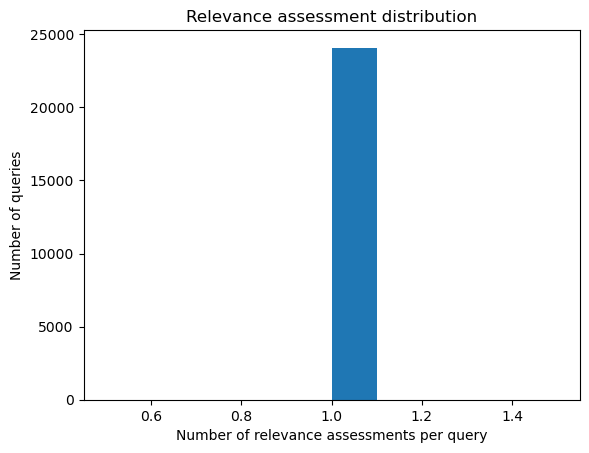

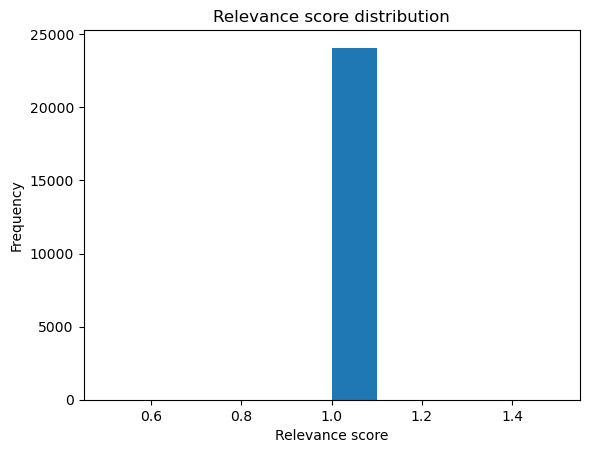

In [43]:
# stats for the qrels
# Count how many relevance assessments each query has
counts = test_qrels.groupby("qid")["docno"].count()  # group by query id and count documents
print('Overall Statistics')
print(counts.describe())  # show a summary of the count distribution

# Plot how many relevance assessments each query received
plt.figure()  # create a new figure
counts.plot(kind='hist')  # histogram showing distribution of judgment counts
plt.xlabel('Number of relevance assessments per query')  # label for x-axis
plt.ylabel('Number of queries')  # label for y-axis
plt.title('Relevance assessment distribution')  # title of the plot
plt.show()  # display the plot

# Show the queries with the highest number of relevance assessments
counts.sort_values(ascending=False).head()  # top queries by number of judgments

# Count how many times each relevance label occurs overall
test_qrels['label'].value_counts()  # distribution of relevance scores (e.g., 0, 1, 2, etc.)

# Plot the label distribution as a histogram
plt.figure()  # create a new figure
test_qrels['label'].plot(kind='hist')  # histogram of relevance labels
plt.xlabel('Relevance score')  # label for x-axis
plt.ylabel('Frequency')  # label for y-axis
plt.title('Relevance score distribution')  # title of the plot
plt.show()  # display the plot

<Axes: >

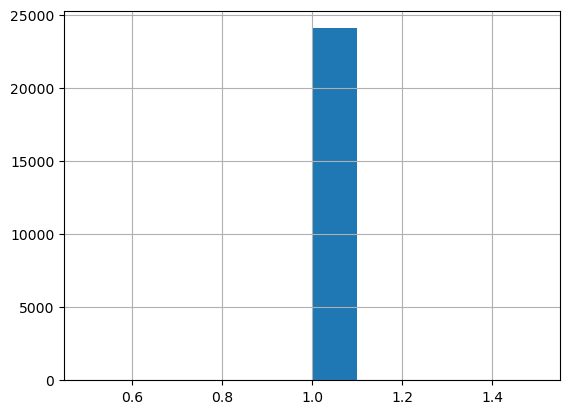

In [44]:
relevant_counts = test_qrels[test_qrels['label'] > 0].groupby("qid")["docno"].count()
relevant_counts.hist()

## Phase I - Topical relevance-based retrieval

non abbiamo le qrels e le questions per il set di test e validation --> le costruiamo

In [45]:
input_file = "data/train.json"
qrels_file = "data/train_qrels.json"
answers_file = "data/train_query_answers.json"
queries_file = "data/train_queries.json"

train_files = ['data/train_qrels.json', 'data/train_query_answers.json', 'data/train_queries.json']

if os.path.exists(qrels_file) and os.path.exists(answers_file) and os.path.exists(queries_file):
    train_dfs = {}
    for input_file in train_files:
        with open(input_file, "r", encoding="utf-8") as f:
            data = json.load(f)
            train_dfs[input_file] = pd.read_json(input_file)

else:
    # Load the data
    with open(input_file, "r", encoding="utf-8") as f:
        train_data = json.load(f)

    # Build the qrels file: query_id, iteration=0, para_id, relevance=1
    train_qrels = [
        {
            "qid": item.get("query_id", ""),
            "iteration": 'Q0',
            "docno": item.get("para_id", ""),
            "label": 1
        }
        for item in train_data
    ]

    # Build the query_answers file: same plus answer and org_answer
    train_query_answers = [
        {
            "query_id": item.get("query_id", ""),
            "iteration": 'Q0',
            "para_id": item.get("para_id", ""),
            "relevance": 1,
            "answer": item.get("answer", ""),
            "org_answer": item.get("org_answer", "")
        }
        for item in train_data
    ]

    def clean_question(text):
        if not isinstance(text, str):
            return ""
        text = unicodedata.normalize("NFKC", text)
        text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)  # remove punctuation
        text = re.sub(r"\s+", " ", text)  # collapse multiple spaces
        return text.strip()

    # Extract and clean
    train_queries = [
        {
            "qid": item.get("query_id", ""),
            "query": clean_question(item.get("question", "")),
        }
        for item in train_data
    ]

    # Sort by query_id (assuming numeric)
    train_queries = sorted(train_queries, key=lambda x: int(x["qid"]) if str(x["qid"]).isdigit() else x["qid"])

    # Keep only the first 10,000
    train_queries = train_queries[:10000]

    # Save both files
    with open(qrels_file, "w", encoding="utf-8") as f:
        json.dump(train_qrels, f, ensure_ascii=False, indent=2)

    with open(answers_file, "w", encoding="utf-8") as f:
        json.dump(train_query_answers, f, ensure_ascii=False, indent=2)

    with open(queries_file, "w", encoding="utf-8") as f:
        json.dump(train_queries, f, ensure_ascii=False, indent=2)

    train_dfs = {}
    for input_file in train_files:
        with open(input_file, "r", encoding="utf-8") as f:
            data = json.load(f)
            train_dfs[input_file] = pd.read_json(input_file)

In [46]:
input_file = "data/validation.json"
qrels_file = "data/validation_qrels.json"
answers_file = "data/validation_query_answers.json"
queries_file = "data/validation_queries.json"

validation_files = ['data/validation_qrels.json', 'data/validation_query_answers.json', 'data/validation_queries.json']

if os.path.exists(qrels_file) and os.path.exists(answers_file) and os.path.exists(queries_file):
    validation_dfs = {}
    for input_file in validation_files:
        with open(input_file, "r", encoding="utf-8") as f:
            data = json.load(f)
            validation_dfs[input_file] = pd.read_json(input_file)

else:
    # Load the data
    with open(input_file, "r", encoding="utf-8") as f:
        validation_data = json.load(f)

    # Build the qrels file: query_id, iteration=0, para_id, relevance=1
    validation_qrels = [
        {
            "qid": item.get("query_id", ""),
            "iteration": 'Q0',
            "docno": item.get("para_id", ""),
            "label": 1
        }
        for item in validation_data
    ]

    # Build the query_answers file: same plus answer and org_answer
    validation_query_answers = [
        {
            "query_id": item.get("query_id", ""),
            "iteration": 'Q0',
            "para_id": item.get("para_id", ""),
            "relevance": 1,
            "answer": item.get("answer", ""),
            "org_answer": item.get("org_answer", "")
        }
        for item in validation_data
    ]

    def clean_question(text):
        if not isinstance(text, str):
            return ""
        text = unicodedata.normalize("NFKC", text)
        text = re.sub(rf"[{re.escape(string.punctuation)}]", " ", text)  # remove punctuation
        text = re.sub(r"\s+", " ", text)  # collapse multiple spaces
        return text.strip()

    # Extract and clean
    validation_queries = [
        {
            "qid": item.get("query_id", ""),
            "query": clean_question(item.get("question", "")),
        }
        for item in validation_data
    ]

    # Sort by query_id (assuming numeric)
    validation_queries = sorted(validation_queries, key=lambda x: int(x["qid"]) if str(x["qid"]).isdigit() else x["qid"])

    # Keep only the first 10,000
    validation_queries = validation_queries[:10000]

    # Save both files
    with open(qrels_file, "w", encoding="utf-8") as f:
        json.dump(validation_qrels, f, ensure_ascii=False, indent=2)

    with open(answers_file, "w", encoding="utf-8") as f:
        json.dump(validation_query_answers, f, ensure_ascii=False, indent=2)

    with open(queries_file, "w", encoding="utf-8") as f:
        json.dump(validation_queries, f, ensure_ascii=False, indent=2)

    validation_dfs = {}
    for input_file in validation_files:
        with open(input_file, "r", encoding="utf-8") as f:
            data = json.load(f)
            validation_dfs[input_file] = pd.read_json(input_file)

In [47]:
train_queries = train_dfs['data/train_queries.json']
train_qrels = train_dfs['data/train_qrels.json']
train_answers = train_dfs['data/train_query_answers.json']

In [48]:
validation_queries = validation_dfs['data/validation_queries.json']
validation_qrels = validation_dfs['data/validation_qrels.json']
validation_answers = validation_dfs['data/validation_query_answers.json']

### **BM25 Retrieval from raw OCR (baseline 1)**

In [57]:
path_to_results = 'expResults/'
results_list = ['res_bm25f_cont_train.csv', 'res_bm25f_cont_validation.csv', 'res_bm25f_cont_test.csv', 'res_bm25f_ocr_train.csv', 'res_bm25f_ocr_validation.csv', 'res_bm25f_ocr_test.csv', 'res_fusion_train.csv', 'res_fusion_validation.csv', 'res_fusion_test.csv']
results_dfs = {}
for result in results_list:
    full_path = path_to_results+result
    if os.path.exists(full_path):
        with open(input_file, "r", encoding="utf-8") as f:
            result_df = pd.read_csv(full_path,
                                header=None,
                                names=['qid', 'iteration', 'docno', 'rank', 'score'])
            result_df = result_df[['qid', 'docno', 'score', 'rank']]
            results_dfs[full_path] = result_df
        uploaded = True
eval_dict = {}
len(results_dfs)

9

In [58]:
results_dfs['expResults/res_bm25f_cont_train.csv']

,qid,docno,score,rank
0,train_1,New_Hampshire_18070804_1,53.448476,0
1,train_1,Delaware_18250407_2,30.185454,1
2,train_1,New_Hampshire_18050730_18,27.820439,2
3,train_1,New_Mexico_18601013_15,26.811384,3
4,train_1,New_York_18591224_35,26.809069,4
...,...,...,...,...
9983458,train_108998,Georgia_19120626_2,7.346475,995
9983459,train_108998,Georgia_19140911_3,7.345915,996
9983460,train_108998,Idaho_18680321_2,7.345285,997
9983461,train_108998,Rhode_Island_18791204_6,7.345285,998


In [59]:
if uploaded:
    res_bm25ocr_train = results_dfs['expResults/res_bm25f_ocr_train.csv']
else:
    bm25ocr = pt.terrier.Retriever(indexrefOCR, wmodel='BM25F', controls={'w.0':'1' , 'w.1':'1.2', 'c.0': '1', 'c.1': '1'}, verbose=True)
    res_bm25ocr_train = (bm25ocr%100).transform(train_queries)

In [60]:
display(res_bm25ocr_train)

,qid,docno,score,rank
0,train_1,New_Hampshire_18070804_1,34.539834,0
1,train_1,New_York_18591224_35,28.483567,1
2,train_1,Tennessee_18570628_25,27.123257,2
3,train_1,Delaware_18250407_2,26.590403,3
4,train_1,Rhode_Island_18531020_3,26.092867,4
...,...,...,...,...
999895,train_108998,Indiana_19031015_3,11.587389,95
999896,train_108998,Maine_18560110_34,11.566983,96
999897,train_108998,Virgin_Islands_of_the_United_States_18690330_1,11.546457,97
999898,train_108998,South_Carolina_18731030_6,11.546457,98


In [61]:
eval_train = pt.Evaluate(res_bm25ocr_train, train_qrels, metrics=['P_1', 'P_5', 'ndcg_cut_5', 'ndcg_cut_10'], perquery=False)
display(eval_train)
eval_dict['bm25_ocr_train'] = eval_train

{'P_1': 0.0076439442570259185,
 'P_5': 0.0021329290556384357,
 'ndcg_cut_5': 0.009254706807771207,
 'ndcg_cut_10': 0.009589066170912422}

In [62]:
if not uploaded:
    import pandas as pd
    import gc
    import pyterrier as pt


    trec_export = res_bm25ocr_train[['qid', 'docno', 'rank', 'score']].copy()


    trec_export['iteration'] = 'Q0'
    trec_export['experiment_id'] = 'BM25F_OCR_train'

    trec_export = trec_export[['qid', 'iteration', 'docno', 'rank', 'score']]

    output_path = "expResults/res_bm25f_ocr_train.csv"
    trec_export.to_csv(output_path, sep=',', index=False, header=False)

    print(f"File salvato con successo in: {output_path}")


In [63]:
if not uploaded:

    del trec_export
    del res_bm25ocr_train


    gc.collect()

    from jnius import autoclass
    System = autoclass('java.lang.System')
    Runtime = autoclass('java.lang.Runtime')

    System.gc()
    Runtime.getRuntime().gc()

    print("Memoria RAM pulita. Puoi procedere con il prossimo run.")

In [64]:
if uploaded:
    res_bm25ocr_validation = results_dfs['expResults/res_bm25f_ocr_validation.csv']
else:
    # validation run
    res_bm25ocr_validation = (bm25ocr%100).transform(validation_queries)

In [65]:
display(res_bm25ocr_validation)

,qid,docno,score,rank
0,val_1,Maine_18100326_13,37.725646,0
1,val_1,Connecticut__19001017_17,30.216711,1
2,val_1,Arkansas_18890426_29,27.877407,2
3,val_1,Georgia_19110519_2,27.571054,3
4,val_1,Massachusetts_18300804_10,27.157041,4
...,...,...,...,...
999795,val_18999,South_Dakota_18880928_13,14.207742,95
999796,val_18999,Maryland_18590108_4,14.193049,96
999797,val_18999,Alabama_19181013_6,14.178289,97
999798,val_18999,Massachusetts_19180711_2,14.162742,98


In [66]:
eval_validation_ocr = pt.Evaluate(res_bm25ocr_validation, validation_qrels, metrics=['P_1', 'P_5', 'ndcg_cut_5', 'ndcg_cut_10'], perquery=False)
display(eval_validation_ocr)
eval_dict['bm25_ocr_validation'] = eval_validation_ocr

{'P_1': 0.18319439260088757,
 'P_5': 0.04875782837709469,
 'ndcg_cut_5': 0.21600711778435286,
 'ndcg_cut_10': 0.22284446394808505}

In [67]:
if not uploaded:
    import pandas as pd
    import gc
    import pyterrier as pt

    trec_export = res_bm25ocr_validation[['qid', 'docno', 'rank', 'score']].copy()


    trec_export['iteration'] = 'Q0'
    trec_export['experiment_id'] = 'BM25F_OCR_validation'


    trec_export = trec_export[['qid', 'iteration', 'docno', 'rank', 'score']]


    output_path = "expResults/res_bm25f_ocr_validation.csv"
    trec_export.to_csv(output_path, sep=',', index=False, header=False)

    print(f"File salvato con successo in: {output_path}")



In [68]:
if not uploaded:

    del trec_export
    del res_bm25ocr_validation


    gc.collect()

    from jnius import autoclass
    System = autoclass('java.lang.System')
    Runtime = autoclass('java.lang.Runtime')

    System.gc()
    Runtime.getRuntime().gc()

    print("Memoria RAM pulita. Puoi procedere con il prossimo run.")

In [69]:
if uploaded:
    res_bm25ocr_test = results_dfs['expResults/res_bm25f_ocr_test.csv']
else:
    # test run ocr
    res_bm25ocr_test = (bm25ocr%100).transform(test_queries)

In [70]:
display(res_bm25ocr_test)

,qid,docno,score,rank
0,test_1,Massachusetts_18490609_20,25.395153,0
1,test_1,New_Hampshire_18060923_6,23.693579,1
2,test_1,New_Hampshire_18030125_16,23.263981,2
3,test_1,New_Hampshire_18070915_20,22.629449,3
4,test_1,New_Jersey_18880911_16,21.941245,4
...,...,...,...,...
999650,test_18999,Connecticut__18861104_33,14.565511,95
999651,test_18999,Nebraska_18580715_20,14.556583,96
999652,test_18999,North_Carolina_18380124_30,14.540523,97
999653,test_18999,North_Dakota_18970325_16,14.514547,98


In [71]:
eval_test_ocr = pt.Evaluate(res_bm25ocr_test, test_qrels, metrics=['P_1', 'P_5', 'ndcg_cut_5', 'ndcg_cut_10'], perquery=False)
display(eval_test_ocr)
eval_dict['bm25_ocr_test'] = eval_test_ocr

{'P_1': 0.17733765155289818,
 'P_5': 0.047874107291152844,
 'ndcg_cut_5': 0.2108677259496851,
 'ndcg_cut_10': 0.2177556490582599}

In [72]:
if not uploaded:
    import pandas as pd
    import gc
    import pyterrier as pt

    trec_export = res_bm25ocr_test[['qid', 'docno', 'rank', 'score']].copy()


    trec_export['iteration'] = 'Q0'
    trec_export['experiment_id'] = 'BM25F_OCR_test'

    trec_export = trec_export[['qid', 'iteration', 'docno', 'rank', 'score']]


    output_path = "expResults/res_bm25f_ocr_test.csv"
    trec_export.to_csv(output_path, sep=',', index=False, header=False)

    print(f"File salvato con successo in: {output_path}")



In [73]:
if not uploaded:

    del trec_export
    del res_bm25ocr_test

    gc.collect()

    from jnius import autoclass
    System = autoclass('java.lang.System')
    Runtime = autoclass('java.lang.Runtime')

    System.gc()
    Runtime.getRuntime().gc()

    print("Memoria RAM pulita. Puoi procedere con il prossimo run.")

### **BM25 Retrieval from corrected OCR (baseline 2)**

In [74]:
if uploaded:
    res_bm25cont_train = results_dfs['expResults/res_bm25f_cont_train.csv']
else:
    bm25cont = pt.terrier.Retriever(indexrefCont, wmodel='BM25F', controls={'w.0':'1' , 'w.1':'1.2', 'c.0': '1', 'c.1': '1'}, verbose=True)
    res_bm25cont_train = bm25cont.transform(train_queries)

In [75]:
display(res_bm25cont_train)

,qid,docno,score,rank
0,train_1,New_Hampshire_18070804_1,53.448476,0
1,train_1,Delaware_18250407_2,30.185454,1
2,train_1,New_Hampshire_18050730_18,27.820439,2
3,train_1,New_Mexico_18601013_15,26.811384,3
4,train_1,New_York_18591224_35,26.809069,4
...,...,...,...,...
9983458,train_108998,Georgia_19120626_2,7.346475,995
9983459,train_108998,Georgia_19140911_3,7.345915,996
9983460,train_108998,Idaho_18680321_2,7.345285,997
9983461,train_108998,Rhode_Island_18791204_6,7.345285,998


In [76]:
eval_train_cont = pt.Evaluate(res_bm25cont_train, train_qrels, metrics=['P_1', 'P_5', 'ndcg_cut_5', 'ndcg_cut_10'], perquery=False)
display(eval_train_cont)
eval_dict['bm25_cont_train'] = eval_train_cont

{'P_1': 0.01403362607044812,
 'P_5': 0.0035711196397927155,
 'ndcg_cut_5': 0.016110881469578116,
 'ndcg_cut_10': 0.016478344435277518}

In [77]:
if not uploaded:
    import pandas as pd
    import gc
    import pyterrier as pt

    trec_export = res_bm25cont_train[['qid', 'docno', 'rank', 'score']].copy()

    trec_export['iteration'] = 'Q0'
    trec_export['experiment_id'] = 'BM25F_cont_train'

    trec_export = trec_export[['qid', 'iteration', 'docno', 'rank', 'score']]

    output_path = "expResults/res_bm25f_cont_train.csv"
    trec_export.to_csv(output_path, sep=',', index=False, header=False)

    print(f"File salvato con successo in: {output_path}")


In [78]:
if not uploaded:

    del trec_export
    del res_bm25cont_train


    gc.collect()

    from jnius import autoclass
    System = autoclass('java.lang.System')
    Runtime = autoclass('java.lang.Runtime')

    System.gc()
    Runtime.getRuntime().gc()

    print("Memoria RAM pulita. Puoi procedere con il prossimo run.")

In [79]:
if uploaded:
    res_bm25cont_validation = results_dfs['expResults/res_bm25f_cont_validation.csv']
else:
    # validation run context
    res_bm25cont_validation = (bm25cont%100).transform(validation_queries)

In [80]:
display(res_bm25cont_validation)

,qid,docno,score,rank
0,val_1,Maine_18100326_13,54.982655,0
1,val_1,New_York_18430702_9,30.661231,1
2,val_1,Connecticut__19001017_17,30.040516,2
3,val_1,Ohio_18381117_16,29.118962,3
4,val_1,Pennsylvania_18001224_18,28.410345,4
...,...,...,...,...
999809,val_18999,Virginia_18480801_28,14.225343,95
999810,val_18999,Maine_18790828_8,14.202033,96
999811,val_18999,Iowa_18700609_9,14.202002,97
999812,val_18999,Arkansas_18321114_2,14.073041,98


In [81]:
eval_validation_cont = pt.Evaluate(res_bm25cont_validation, validation_qrels, metrics=['P_1', 'P_5', 'ndcg_cut_5', 'ndcg_cut_10'], perquery=False)
display(eval_validation_cont)
eval_dict['bm25_cont_validation'] = eval_validation_cont

{'P_1': 0.25784911451204845,
 'P_5': 0.06517357222845258,
 'ndcg_cut_5': 0.2947828592794792,
 'ndcg_cut_10': 0.30102942654946396}

In [82]:
if not uploaded:
    import pandas as pd
    import gc
    import pyterrier as pt

    trec_export = res_bm25cont_validation[['qid', 'docno', 'rank', 'score']].copy()


    trec_export['iteration'] = 'Q0'
    trec_export['experiment_id'] = 'BM25F_cont_validation'


    trec_export = trec_export[['qid', 'iteration', 'docno', 'rank', 'score']]

    output_path = "expResults/res_bm25f_cont_validation.csv"
    trec_export.to_csv(output_path, sep=',', index=False, header=False)

    print(f"File salvato con successo in: {output_path}")

In [83]:
if not uploaded:
    del trec_export
    del res_bm25cont_validation

    gc.collect()

    from jnius import autoclass
    System = autoclass('java.lang.System')
    Runtime = autoclass('java.lang.Runtime')

    System.gc()
    Runtime.getRuntime().gc()

    print("Memoria RAM pulita. Puoi procedere con il prossimo run.")

In [84]:
if uploaded:
    res_bm25cont_test = results_dfs['expResults/res_bm25f_cont_test.csv']
else:
    # test run context
    res_bm25cont_test = (bm25cont%100).transform(test_queries)

In [85]:
display(res_bm25cont_test)

,qid,docno,score,rank
0,test_1,New_Hampshire_18060923_6,25.748664,0
1,test_1,Massachusetts_18490609_20,25.049406,1
2,test_1,Rhode_Island_19070909_15,22.788655,2
3,test_1,New_Hampshire_18001028_9,22.502363,3
4,test_1,New_Hampshire_18070915_20,21.921950,4
...,...,...,...,...
999689,test_18999,New_York_18780703_32,14.615348,95
999690,test_18999,Hawaii_18461226_15,14.610640,96
999691,test_18999,Montana_18650624_18,14.609995,97
999692,test_18999,Vermont_19000525_2,14.580107,98


In [86]:
eval_test_cont = pt.Evaluate(res_bm25cont_test, test_qrels, metrics=['P_1', 'P_5', 'ndcg_cut_5', 'ndcg_cut_10'], perquery=False)
display(eval_test_cont)
eval_dict['bm25_cont_test'] = eval_test_cont

{'P_1': 0.2559790732436472,
 'P_5': 0.06422521175885296,
 'ndcg_cut_5': 0.29153852966188676,
 'ndcg_cut_10': 0.29846681241080086}

In [87]:
if not uploaded:
    import pandas as pd
    import gc
    import pyterrier as pt
    trec_export = res_bm25cont_test[['qid', 'docno', 'rank', 'score']].copy()

    trec_export['iteration'] = 'Q0'
    trec_export['experiment_id'] = 'BM25F_cont_test'

    trec_export = trec_export[['qid', 'iteration', 'docno', 'rank', 'score']]

    output_path = "expResults/res_bm25f_cont_test.csv"
    trec_export.to_csv(output_path, sep=',', index=False, header=False)

    print(f"File salvato con successo in: {output_path}")

In [88]:
if not uploaded:
    del trec_export
    del res_bm25cont_test

    gc.collect()

    from jnius import autoclass
    System = autoclass('java.lang.System')
    Runtime = autoclass('java.lang.Runtime')

    System.gc()
    Runtime.getRuntime().gc()

    print("Memoria RAM pulita. Puoi procedere con il prossimo run.")

### **BM25 Retrieval from both raw and corrected OCR using RRF formula (baseline 3)**


In [89]:
if uploaded:
    res_fusion_train = results_dfs['expResults/res_fusion_train.csv']
else:
    fusion_transf = pt_alpha.RRFusion(bm25ocr, bm25cont, num_results=100)
    res_fusion_train = fusion_transf.transform(train_queries)

In [90]:
display(res_fusion_train)

,qid,docno,score,rank
0,train_1,New_Hampshire_18070804_1,0.033333,0
1,train_1,Delaware_18250407_2,0.032266,1
2,train_1,New_York_18591224_35,0.032018,2
3,train_1,New_Hampshire_18050730_18,0.031514,3
4,train_1,Tennessee_18570628_25,0.031054,4
...,...,...,...,...
999896,train_108998,New_York_18800924_8,0.011628,96
999897,train_108998,Washington_18970331_27,0.011541,97
999898,train_108998,Missouri_18400307_19,0.011534,98
999899,train_108998,Maine_18990620_14,0.011494,99


In [91]:
eval_train_fusion = pt.Evaluate(res_fusion_train, train_qrels, metrics=['P_1', 'P_5', 'ndcg_cut_5', 'ndcg_cut_10'], perquery=False)
display(eval_train_fusion)
eval_dict['fusion_train'] = eval_train_fusion

{'P_1': 0.008467978748104949,
 'P_5': 0.00233506790317389,
 'ndcg_cut_5': 0.010202337934154539,
 'ndcg_cut_10': 0.010626326738914692}

In [92]:
if not uploaded:
    import pandas as pd
    import gc
    import pyterrier as pt

    trec_export = res_fusion_train[['qid', 'docno', 'rank', 'score']].copy()

    trec_export['iteration'] = 'Q0'
    trec_export['experiment_id'] = 'Fusion_train'

    trec_export = trec_export[['qid', 'iteration', 'docno', 'rank', 'score']]

    output_path = "expResults/res_fusion_train.csv"
    trec_export.to_csv(output_path, sep=',', index=False, header=False)

    print(f"File salvato con successo in: {output_path}")

In [93]:
if not uploaded:
    del trec_export
    del res_fusion_train

    gc.collect()

    from jnius import autoclass
    System = autoclass('java.lang.System')
    Runtime = autoclass('java.lang.Runtime')

    System.gc()
    Runtime.getRuntime().gc()
    print("Memoria RAM pulita. Puoi procedere con il prossimo run.")

In [94]:
if uploaded:
    res_fusion_validation = results_dfs['expResults/res_fusion_validation.csv']
else:
    res_fusion_validation = fusion_transf.transform(validation_queries)

In [95]:
display(res_fusion_validation)

,qid,docno,score,rank
0,val_1,Maine_18100326_13,0.033333,0
1,val_1,Connecticut__19001017_17,0.032522,1
2,val_1,Arkansas_18890426_29,0.031281,2
3,val_1,Ohio_18381117_16,0.031258,3
4,val_1,Georgia_19110519_2,0.030798,4
...,...,...,...,...
999849,val_18999,Montana_19091224_13,0.011970,96
999850,val_18999,Maryland_18821118_19,0.011968,97
999851,val_18999,Arkansas_18480329_28,0.011928,98
999852,val_18999,Kansas_18900918_28,0.011895,99


In [96]:
eval_validation_fusion = pt.Evaluate(res_fusion_validation, validation_qrels, metrics=['P_1', 'P_5', 'ndcg_cut_5', 'ndcg_cut_10'], perquery=False)
display(eval_validation_fusion)
eval_dict['fusion_validation'] = eval_validation_fusion

{'P_1': 0.1951391481066733,
 'P_5': 0.052017751233882796,
 'ndcg_cut_5': 0.23053043344318627,
 'ndcg_cut_10': 0.23831403431822393}

In [97]:
if not uploaded:
    import pandas as pd
    import gc
    import pyterrier as pt


    trec_export = res_fusion_validation[['qid', 'docno', 'rank', 'score']].copy()

    trec_export['iteration'] = 'Q0'
    trec_export['experiment_id'] = 'Fusion_validation'

    trec_export = trec_export[['qid', 'iteration', 'docno', 'rank', 'score']]

    output_path = "expResults/res_fusion_validation.csv"
    trec_export.to_csv(output_path, sep=',', index=False, header=False)

    print(f"File salvato con successo in: {output_path}")


In [98]:
if not uploaded:
    del trec_export
    del res_fusion_validation

    gc.collect()

    from jnius import autoclass
    System = autoclass('java.lang.System')
    Runtime = autoclass('java.lang.Runtime')

    System.gc()
    Runtime.getRuntime().gc()

    print("Memoria RAM pulita. Puoi procedere con il prossimo run.")

In [99]:
if uploaded:
    res_fusion_test = results_dfs['expResults/res_fusion_test.csv']
else:
    res_fusion_test = fusion_transf.transform(test_queries)

In [100]:
display(res_fusion_test)

,qid,docno,score,rank
0,test_1,Massachusetts_18490609_20,0.033060,0
1,test_1,New_Hampshire_18060923_6,0.033060,1
2,test_1,New_Hampshire_18070915_20,0.031498,2
3,test_1,Rhode_Island_19070909_15,0.031054,3
4,test_1,New_Jersey_18880911_16,0.031010,4
...,...,...,...,...
999732,test_18999,Tennessee_18811127_29,0.012285,95
999733,test_18999,Virginia_18690524_34,0.012272,96
999734,test_18999,Connecticut__18861104_33,0.012266,97
999735,test_18999,Tennessee_18570527_18,0.012192,98


In [101]:
eval_test_fusion = pt.Evaluate(res_fusion_test, test_qrels, metrics=['P_1', 'P_5', 'ndcg_cut_5', 'ndcg_cut_10'], perquery=False)
display(eval_test_fusion)
eval_dict['fusion_test'] = eval_test_fusion

{'P_1': 0.19153795050656036,
 'P_5': 0.05122903172231122,
 'ndcg_cut_5': 0.22650061415753533,
 'ndcg_cut_10': 0.23439994732749872}

In [102]:
if not uploaded:
    import pandas as pd
    import gc
    import pyterrier as pt

    trec_export = res_fusion_test[['qid', 'docno', 'rank', 'score']].copy()

    trec_export['iteration'] = 'Q0'
    trec_export['experiment_id'] = 'Fusion_test'

    trec_export = trec_export[['qid', 'iteration', 'docno', 'rank', 'score']]

    output_path = "expResults/res_fusion_test.csv"
    trec_export.to_csv(output_path, sep=',', index=False, header=False)

    print(f"File salvato con successo in: {output_path}")

In [103]:
if not uploaded:
    del trec_export
    del res_fusion_test

    gc.collect()

    from jnius import autoclass
    System = autoclass('java.lang.System')
    Runtime = autoclass('java.lang.Runtime')

    System.gc()
    Runtime.getRuntime().gc()

    print("Memoria RAM pulita. Puoi procedere con il prossimo run.")

In [111]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

rows = []
for key, metrics in eval_dict.items():
    parts = key.split('_')
    split = parts[-1]
    baseline_name = "_".join(parts[:-1])

    row = {'baseline': baseline_name, 'split': split}
    row.update(metrics)
    rows.append(row)

df = pd.DataFrame(rows)

df['split'] = pd.Categorical(df['split'], categories=['train', 'validation', 'test'], ordered=True)
df = df.sort_values(['baseline', 'split'])

In [112]:
pivot_ndcg = df.pivot(index='baseline', columns='split', values='ndcg_cut_10')

pivot_p1 = df.pivot(index='baseline', columns='split', values='P_1')

print("### Confronto nDCG@10 ###")
print(pivot_ndcg)
print("\n### Confronto P@1 ###")
print(pivot_p1)

### Confronto nDCG@10 ###
split         train  validation      test
baseline                                 
bm25_cont  0.016478    0.301029  0.298467
bm25_ocr   0.009589    0.222844  0.217756
fusion     0.010626    0.238314  0.234400

### Confronto P@1 ###
split         train  validation      test
baseline                                 
bm25_cont  0.014034    0.257849  0.255979
bm25_ocr   0.007644    0.183194  0.177338
fusion     0.008468    0.195139  0.191538


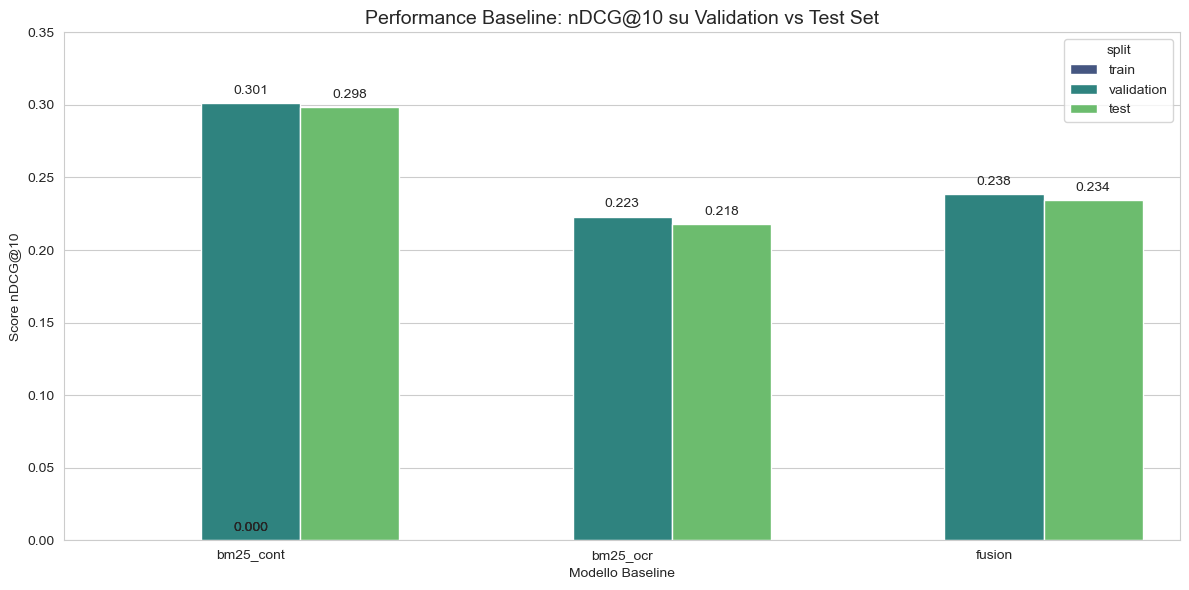

In [113]:
df_plot = df[df['split'].isin(['validation', 'test'])]

plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

ax = sns.barplot(data=df_plot, x='baseline', y='ndcg_cut_10', hue='split', palette='viridis')

plt.title('Performance Baseline: nDCG@10 su Validation vs Test Set', fontsize=14)
plt.ylabel('Score nDCG@10')
plt.xlabel('Modello Baseline')
plt.ylim(0, 0.35)

for p in ax.patches:
    ax.annotate(format(p.get_height(), '.3f'),
                   (p.get_x() + p.get_width() / 2., p.get_height()),
                   ha = 'center', va = 'center',
                   xytext = (0, 9),
                   textcoords = 'offset points')

plt.tight_layout()
plt.show()

In [115]:
# --- 4. ANALISI DEL MIGLIORAMENTO ---
test_results = df[df['split'] == 'test'].set_index('baseline')
best_baseline = test_results['ndcg_cut_10'].idxmax()
best_score = test_results['ndcg_cut_10'].max()

print(f"\nANALISI FINALE:")
print(f"La migliore baseline su test set è: {best_baseline} con nDCG@10 = {best_score:.4f}")


ANALISI FINALE:
La migliore baseline su test set è: bm25_cont con nDCG@10 = 0.2985


## Phase II - Re-ranking experiments ...